# Prepare run

## Import libraries and functions

Using a Pytorch-based CREsted environment with tangermeme installed

In [1]:
import os
import torch
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
import crested
import anndata
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from crested.tl.data import AnnDataModule
from scipy.stats import pearsonr, spearmanr
from crested.tl import default_configs, TaskConfig

import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

## Setup directories

Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [ ]:
data_dir = Path("../../../crested_data/Figure_4/deepccl")
output_dir = Path(f'results/modisco')
output_path = data_dir.joinpath(output_dir)

# DeepCCL enhancer code analysis (Figure 4e)

### Load modisco results for each model (obtained for each model separately as shown in the CREsted tutorial)

In [5]:
labels = ['A172', 'GM12878', 'HepG2', 'LN229', 'M059J', 'MM001', 'MM029', 'MM099']
classes_of_interest = ['a172', 'gm12878', 'hepg2', 'ln229', 'm059j', 'mm001', 'mm029', 'mm099']

matched_files = {}
matched_files_bs = crested.tl.modisco.match_h5_files_to_classes(
    classes=classes_of_interest,
    contribution_dir=output_path.joinpath(Path('base_model')),
)
matched_files_ft = crested.tl.modisco.match_h5_files_to_classes(
    classes=classes_of_interest,
    contribution_dir=output_path.joinpath(Path('finetuned_model'))
)

for key, value in matched_files_bs.items():
    matched_files[f'{key}_bs'] = value

for key, value in matched_files_ft.items():
    matched_files[f'{key}_ft'] = value

### Match patterns across cell lines for both base and finetuned model

In [6]:
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=3.5,
    trim_ic_threshold=0.1,
    discard_ic_threshold=0.2,
    verbose=True,
)

pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count",
)
pattern_matrix.shape

Reading file /staging/leuven/stg_00002/lcb/vkonst/Projects/CREsted/data/deepccl/results/modisco/base_model/a172_modisco_results.h5
Match between a172_bs_pos_patterns_5 and a172_bs_pos_patterns_3 with similarity score 5.62
Match between a172_bs_pos_patterns_10 and a172_bs_pos_patterns_2 with similarity score 3.87
Match between a172_bs_pos_patterns_11 and a172_bs_pos_patterns_3 with similarity score 4.00
Match between a172_bs_pos_patterns_13 and a172_bs_pos_patterns_1 with similarity score 4.03
Match between a172_bs_pos_patterns_15 and a172_bs_pos_patterns_3 with similarity score 4.43
Reading file /staging/leuven/stg_00002/lcb/vkonst/Projects/CREsted/data/deepccl/results/modisco/base_model/gm12878_modisco_results.h5
Match between gm12878_bs_neg_patterns_1 and a172_bs_pos_patterns_2 with similarity score 4.09
Match between gm12878_bs_pos_patterns_2 and gm12878_bs_pos_patterns_1 with similarity score 4.53
Match between gm12878_bs_pos_patterns_3 and a172_bs_pos_patterns_4 with similarity sc

(16, 84)

Cluster to tf annotations

In [7]:
# Manually annotated clusters
cluster_to_tf = {
    1: 'AP-1',
    2: 'KLF',
    3: 'TEAD',
    4: 'NFI',
    5: 'RUNX',
    6: 'ATF/CREB',
    7: 'ETS',
    8: 'NFKB',
    9: 'CTCF',
    10: 'MITF',
    13: 'IRF',
    21: 'FOX',
    23: 'FOXA',
    24: 'CEBP',
    27: 'TFAP2',
    28: 'TFAP2 + ZEB',
    30: 'SOX',
    31: 'LEF/TCF',
    32: 'MITF',
    33: 'ZEB',
    36: 'AP-1 + RUNX',
    45: 'TCF',
    46: 'GATA',
    51: 'HOX',
    54: 'MAF',
    63: 'NFAT',
    64: 'SOX',
    65: 'ZEB',
    79: 'SIX'
}

## Seqlet correlation between MES classes (Figure 4e)

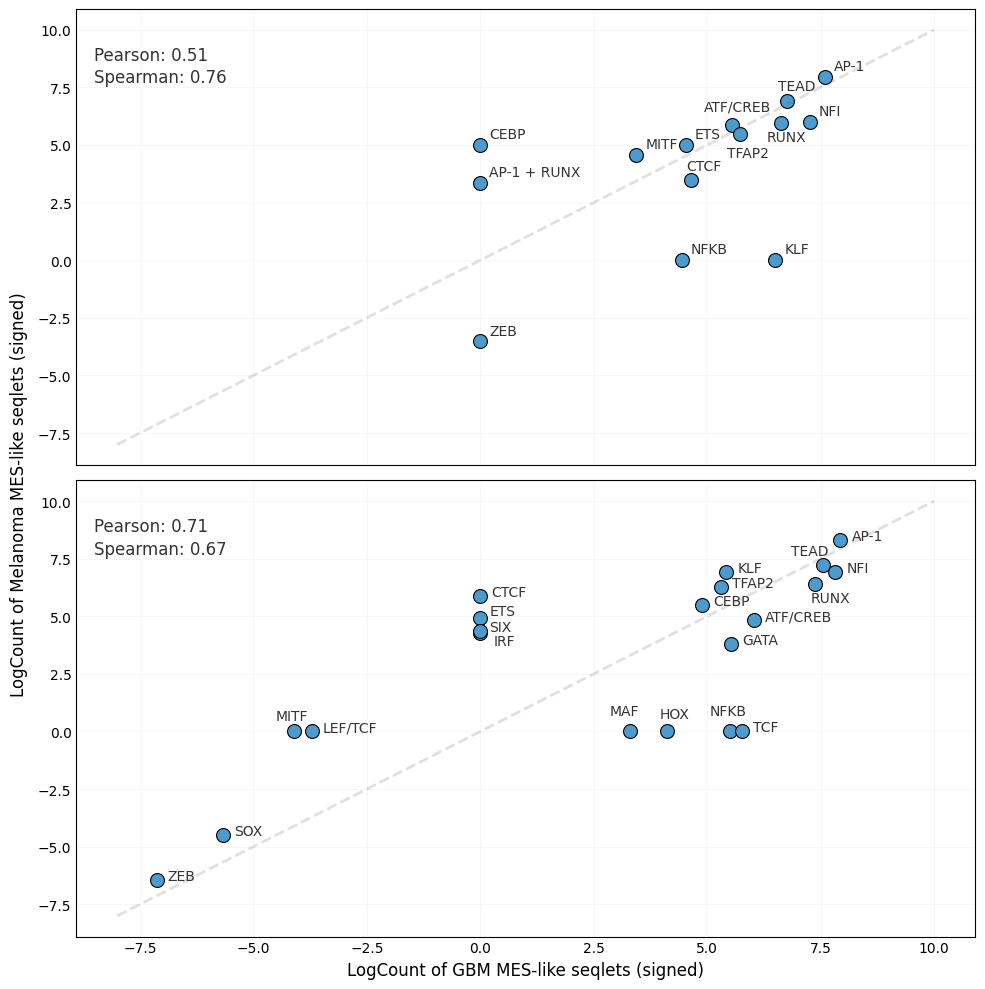

In [8]:
# Function to log-transform counts but keeping the sign of the contribution scores
def signed_log_transform(x):
    return np.sign(x) * np.log1p(abs(x))

# Prepare pattern matrix and remove noisy instances 
all_patterns['27']['pattern'] = all_patterns['27']['instances']['ln229_bs_pos_patterns_3']
all_patterns['6']['pattern'] = all_patterns['6']['instances']['mm029_bs_pos_patterns_7']
all_patterns['30']['pattern'] = all_patterns['30']['instances']['ln229_ft_pos_patterns_1']
all_patterns['46']['pattern'] = all_patterns['46']['instances']['a172_ft_pos_patterns_7']
columns_to_delete = [11, 39, 40, 42, 43, 47, 60, 70, 71, 72, 73, 74]
pattern_matrix[:, columns_to_delete] = 0

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 10))  # Stacked with shared x and y axes

### === FIRST PLOT (axs[0]) === ###
# Selecting the relevant classes (GBM and Melanoma cell lines [Base model])
selected_rows = [0, 4, 6, 7]
columns_to_drop = [0, 26, 34, 35, 37, 38]
subset_pattern_matrix = pattern_matrix[selected_rows, :]
subset_pattern_matrix = pd.DataFrame(subset_pattern_matrix, columns=[cluster_to_tf.get(x, x) for x in range(pattern_matrix.shape[1])])
subset_pattern_matrix = subset_pattern_matrix.drop(columns_to_drop, axis=1)

df = subset_pattern_matrix.T
df.columns = [list(matched_files.keys())[i] for i in selected_rows]

df["GBM_MES"] = df.iloc[:, 0] + df.iloc[:, 1]
df["MEL_MES"] = df.iloc[:, 2] + df.iloc[:, 3]
df = df[~((df["GBM_MES"] == 0) & (df["MEL_MES"] == 0))]

df["GBM_MES"] = df["GBM_MES"].apply(signed_log_transform)
df["MEL_MES"] = df["MEL_MES"].apply(signed_log_transform)

pearson_corr, _ = pearsonr(df["GBM_MES"], df["MEL_MES"])
spearman_corr, _ = spearmanr(df["GBM_MES"], df["MEL_MES"])
sns.scatterplot(ax=axs[0], x=df["GBM_MES"], y=df["MEL_MES"], color="#4C9BCE", s=100, edgecolor='black', marker='o')

# Add y = x baseline
axs[0].plot([-8, 10], [-8, 10], linestyle="--", color="#666666", alpha=0.2, linewidth=2)

# Add correlation coefficients
axs[0].text(0.02, 0.92, f"Pearson: {pearson_corr:.2f}", ha='left', va='top', fontsize=12, color='#333333', transform=axs[0].transAxes)
axs[0].text(0.02, 0.87, f"Spearman: {spearman_corr:.2f}", ha='left', va='top', fontsize=12, color='#333333', transform=axs[0].transAxes)

axs[0].grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.1)
axs[0].set_facecolor('white')
axs[0].tick_params(axis='both', which='both', length=0)

# Add annotations
for i, row in df.iterrows():
    if i == 'ATF/CREB':
        axs[0].text(row["GBM_MES"] - 0.6, row["MEL_MES"] + 0.6, i, 
                    horizontalalignment='left', size=10, color='#333333')
    elif i == 'RUNX':
        axs[0].text(row["GBM_MES"] - 0.3, row["MEL_MES"] - 0.8, i, 
                    horizontalalignment='left', size=10, color='#333333')
    elif i == 'TEAD':
        axs[0].text(row["GBM_MES"] - 0.2, row["MEL_MES"] + 0.5, i, 
                    horizontalalignment='left', size=10, color='#333333')
    elif i == 'TFAP2':
        axs[0].text(row["GBM_MES"] - 0.3, row["MEL_MES"] - 1.0, i, 
                    horizontalalignment='left', size=10, color='#333333')
    elif i == 'CTCF':
        axs[0].text(row["GBM_MES"] - 0.1, row["MEL_MES"] + 0.4, i, 
                    horizontalalignment='left', size=10, color='#333333')
    else:
        axs[0].text(row["GBM_MES"] + 0.2, row["MEL_MES"] + 0.3, i, 
                    horizontalalignment='left', size=10, color='#333333')


### === SECOND PLOT (axs[1]) === ###
# Selecting the relevant classes (GBM and Melanoma cell lines [Finetuned model])
selected_rows = [8, 12, 14, 15]
columns_to_drop = [0, 19, 25, 26, 29, 34, 35, 37, 38, 41, 44, 48, 49, 50, 52, 53, 55, 62, 68, 69, 75, 76, 77, 78, 80, 81, 82, 83]
subset_pattern_matrix = pattern_matrix[selected_rows, :]
subset_pattern_matrix = pd.DataFrame(subset_pattern_matrix, columns=[cluster_to_tf.get(x, x) for x in range(pattern_matrix.shape[1])])
subset_pattern_matrix = subset_pattern_matrix.drop(columns_to_drop, axis=1)

df = subset_pattern_matrix.T
df.columns = [list(matched_files.keys())[i] for i in selected_rows]

df["GBM_MES"] = df.iloc[:, 0] + df.iloc[:, 1]
df["MEL_MES"] = df.iloc[:, 2] + df.iloc[:, 3]
df = df[~((df["GBM_MES"] == 0) & (df["MEL_MES"] == 0))]

df["GBM_MES"] = df["GBM_MES"].apply(signed_log_transform)
df["MEL_MES"] = df["MEL_MES"].apply(signed_log_transform)

pearson_corr, _ = pearsonr(df["GBM_MES"], df["MEL_MES"])
spearman_corr, _ = spearmanr(df["GBM_MES"], df["MEL_MES"])
sns.scatterplot(ax=axs[1], x=df["GBM_MES"], y=df["MEL_MES"], color="#4C9BCE", s=100, edgecolor='black', marker='o')

# Add y = x baseline
axs[1].plot([-8, 10], [-8, 10], linestyle="--", color="#666666", alpha=0.2, linewidth=2)

# Add correlation coefficients
axs[1].text(0.02, 0.92, f"Pearson: {pearson_corr:.2f}", ha='left', va='top', fontsize=12, color='#333333', transform=axs[1].transAxes)
axs[1].text(0.02, 0.87, f"Spearman: {spearman_corr:.2f}", ha='left', va='top', fontsize=12, color='#333333', transform=axs[1].transAxes)

axs[1].grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.1)
axs[1].set_facecolor('white')
axs[1].tick_params(axis='both', which='both', length=0)

# Add annotations and adjust placement
for i, row in df.iterrows():
    if i == 'MITF':
        axs[1].text(row["GBM_MES"] - 0.4, row["MEL_MES"] + 0.5, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i in ['MAF', 'NFKB']:
        axs[1].text(row["GBM_MES"] - 0.45, row["MEL_MES"] + 0.7, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'HOX':
        axs[1].text(row["GBM_MES"] - 0.15, row["MEL_MES"] + 0.6, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'IRF':
        axs[1].text(row["GBM_MES"] + 0.3, row["MEL_MES"] - 0.5, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'SIX':
        axs[1].text(row["GBM_MES"] + 0.2, row["MEL_MES"], i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'ETS':
        axs[1].text(row["GBM_MES"] + 0.2, row["MEL_MES"] + 0.1, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'TEAD':
        axs[1].text(row["GBM_MES"] - 0.7, row["MEL_MES"] + 0.4, i, 
                      horizontalalignment='left', size=10, color='#333333')
    elif i == 'RUNX':
        axs[1].text(row["GBM_MES"] - 0.1, row["MEL_MES"] - 0.8, i, 
                      horizontalalignment='left', size=10, color='#333333')
    else:
        axs[1].text(row["GBM_MES"] + 0.25, row["MEL_MES"], i, 
                      horizontalalignment='left', size=10, color='#333333')

# Set one common y-axis label
fig.supylabel("LogCount of Melanoma MES-like seqlets (signed)", fontsize=12, family='sans-serif')
axs[0].set_ylabel("")
axs[1].set_ylabel("")

# Set x-axis label only on the last subplot
axs[1].set_xlabel("LogCount of GBM MES-like seqlets (signed)", fontsize=12, family='sans-serif')

plt.tight_layout()
plt.show()